In [1]:
import numpy as np
import trace_gen as tg # source code at: https://github.com/Effygal/trace-gen
import matplotlib.pyplot as plt
import heapq
import seaborn as sns
import pandas as pd
import matplotlib.ticker as ticker
plt.rcParams['pdf.fonttype'] = 42 
plt.rcParams['ps.fonttype'] = 42 
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['text.usetex']  = False
palette = sns.color_palette("deep")

In [2]:
def sim_clock(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(1, M, K)
    hr_clock = [tg.sim_clock(int(_c), trace, raw=True) for _c in c]
    return c, hr_clock

def sim_ran_clock_rp(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(1, M, K)
    hr_ran_clock = [tg.sim_ran_clock(int(_c), trace, raw=True, rp=True) for _c in c]
    return c, hr_ran_clock

def sim_ran_clock_no_rp(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(1, M, K)
    hr_ran_clock = [tg.sim_ran_clock(int(_c), trace, raw=True, rp=False) for _c in c]
    return c, hr_ran_clock

def sim_sieve(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(1, M, K)
    hr_sieve = [tg.sim_sieve(int(_c), trace, raw=True) for _c in c]
    return c, hr_sieve

def sim_lru(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(1, M, K)
    hr_lru = [tg.sim_lru(int(_c), trace, raw=True) for _c in c]
    return c, hr_lru

def sim_fifo(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(1, M, K)
    hr_fifo = [tg.sim_fifo(int(_c), trace, raw=True) for _c in c]
    return c, hr_fifo

def gen_from_zipf(M, n, a):
    ranks = np.arange(1, M+1)
    p = ranks**(-a)
    p /= p.sum()
    return p, np.random.choice(M, size=n, p=p)

# def gen_from_iat(lmb, M, n): # buggy
#     lmb = np.asarray(lmb, dtype=float)
#     def sample_ird():
#         lam = np.random.choice(lmb, p=lmb)
#         # return np.random.exponential(1.0 / lam) 
#         return np.random.geometric(lam)
#     h = [(sample_ird(), i) for i in range(M)]
#     heapq.heapify(h)
#     trace = []
#     for _ in range(n):
#         t, addr = heapq.heappop(h)
#         trace.append(addr)
#         heapq.heappush(h, (t + sample_ird(), addr))
#     return np.array(trace, dtype=np.int32)
def gen_from_iad(f, M, n):
    # f(): returns a positive integer IAD sample
    h = [(f(), i) for i in range(M)]
    heapq.heapify(h)
    trace = []
    for _ in range(n):
        t, addr = heapq.heappop(h)
        trace.append(addr)
        heapq.heappush(h, (t + f(), addr))
    return np.array(trace, dtype=np.int32)

In [3]:
lmb, trace1 = gen_from_zipf(10000, 1000000, 0.6)
iads1 = tg.iad(trace1)
iads1 = iads1[iads1 > 0]
f = lambda: int(np.random.choice(iads1))
trace2 = gen_from_iad(f, 10000, 1000000)

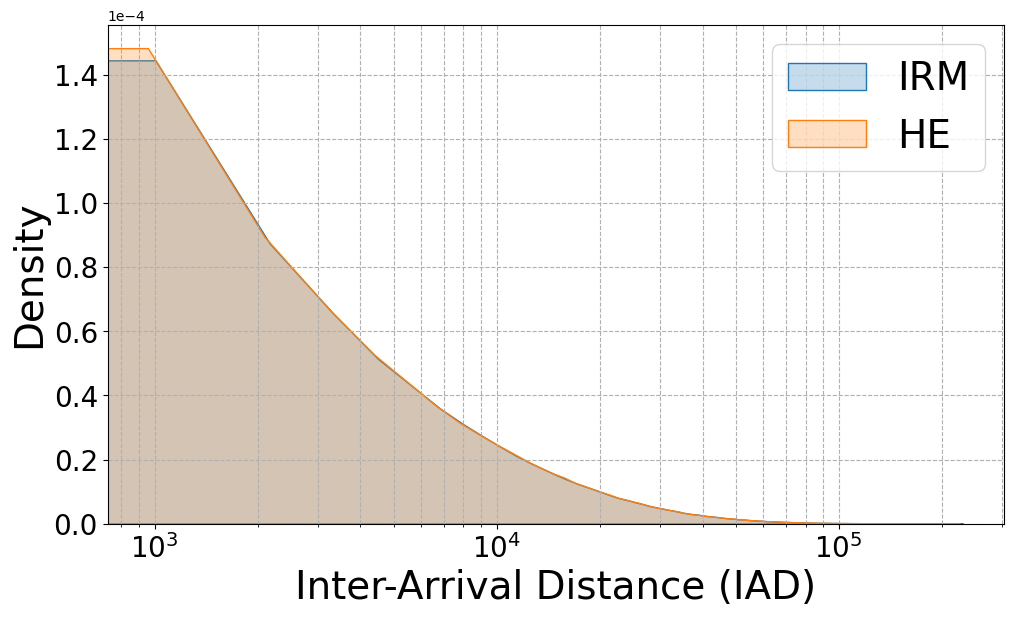

In [8]:
# iads should match
iads2 = tg.iad(trace2)
iads2 = iads2[iads2 > 0]
plt.figure(figsize=(10,6))
sns.kdeplot(iads1, bw_adjust=0.5, label='IRM', fill=True)
sns.kdeplot(iads2, bw_adjust=0.5, label='HE', fill=True)
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.xaxis.get_major_formatter().set_scientific(True)
ax.xaxis.get_major_formatter().set_powerlimits((-1, 1))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.get_major_formatter().set_scientific(True)
ax.yaxis.get_major_formatter().set_powerlimits((-1, 1))
ax.tick_params(axis='both',  labelsize=20)
plt.tight_layout()
plt.xscale('log')
plt.xlabel('Inter-Arrival Distance (IAD)', fontsize=28)
plt.ylabel('Density', fontsize=28)
plt.legend(fontsize=28)
plt.grid(True, which="both", ls="--")
plt.show()

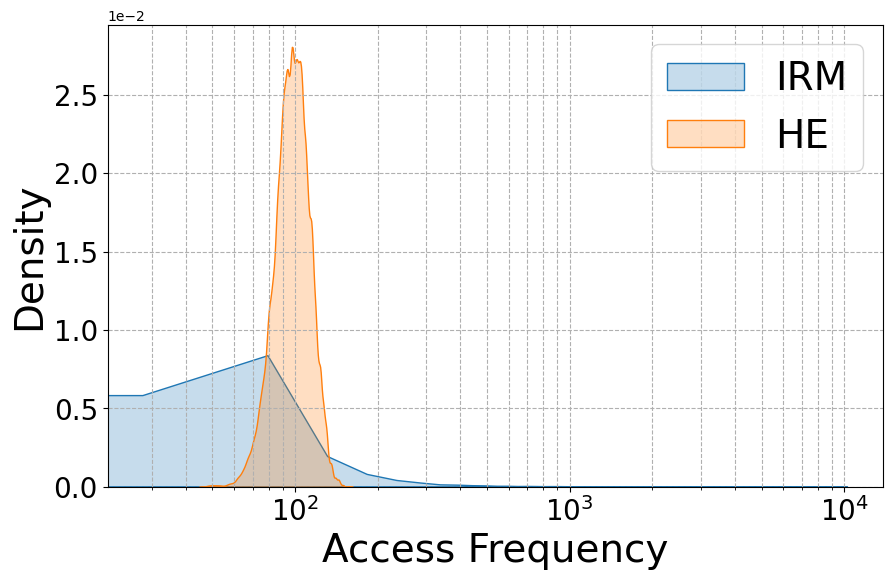

In [9]:
# frequency should not match
u1, c1 = np.unique(trace1, return_counts=True)
u2, c2 = np.unique(trace2, return_counts=True)
plt.figure(figsize=(10,6))
sns.kdeplot(c1, bw_adjust=0.5, label='IRM', fill=True)
sns.kdeplot(c2, bw_adjust=0.5, label='HE', fill=True)
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.xaxis.get_major_formatter().set_scientific(True)
ax.xaxis.get_major_formatter().set_powerlimits((-1, 1))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.get_major_formatter().set_scientific(True)
ax.yaxis.get_major_formatter().set_powerlimits((-1, 1))
ax.tick_params(axis='both',  labelsize=20)
plt.xscale('log')
plt.xlabel('Access Frequency', fontsize=28)
plt.ylabel('Density', fontsize=28)
plt.legend(fontsize=28)
plt.grid(True, which="both", ls="--")
plt.show()

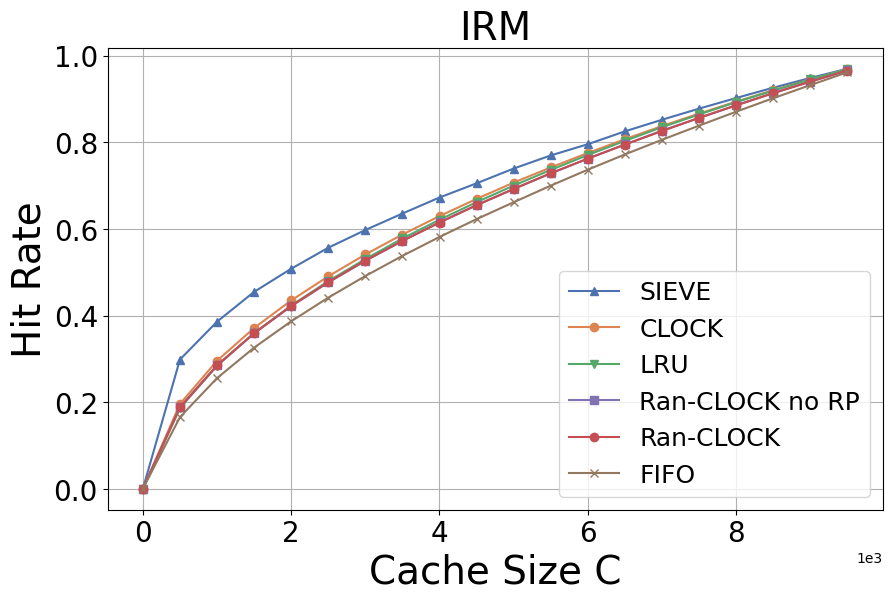

IRM Average Hit Rates:
SIEVE: 0.6714723
CLOCK: 0.6343748499999999
LRU: 0.62836565
Ran-CLOCK no RP: 0.62371145
Ran-CLOCK: 0.62364475
FIFO: 0.5998989499999999


In [36]:
c, hr_ran_clock = sim_ran_clock_rp(trace1)
cn, hr_ran_clock_no_rp = sim_ran_clock_no_rp(trace1)
cc, hr_clock = sim_clock(trace1)
cs, hr_sieve = sim_sieve(trace1)
cl, hr_lru = sim_lru(trace1)
cf, hr_fifo = sim_fifo(trace1)

plt.figure(figsize=(10,6))
ax = plt.gca()
ax.tick_params(axis='both', labelsize=20)
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.xaxis.get_major_formatter().set_scientific(True)
ax.xaxis.get_major_formatter().set_powerlimits((-1, 1))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.get_major_formatter().set_scientific(True)
ax.yaxis.get_major_formatter().set_powerlimits((-1, 1))
plt.plot(cs, hr_sieve, color=palette[0], marker='^', label='SIEVE')
plt.plot(cc, hr_clock, color=palette[1], marker='o', label='CLOCK')
plt.plot(cl, hr_lru, color=palette[2], marker='v', label='LRU')
plt.plot(cn, hr_ran_clock_no_rp, color=palette[4], marker='s', label='Ran-CLOCK no RP')
plt.plot(c, hr_ran_clock, color=palette[3], marker='o', label='Ran-CLOCK')
plt.plot(cf, hr_fifo, color=palette[5], marker='x', label='FIFO')
plt.xlabel('Cache Size C', fontsize=28)
plt.ylabel('Hit Rate', fontsize=28)
plt.legend(fontsize=18)
plt.title('IRM', fontsize=28)
plt.grid(True)
plt.show()

avgs = [('SIEVE', np.mean(np.array(hr_sieve))),
        ('CLOCK', np.mean(np.array(hr_clock))),
        ('LRU', np.mean(np.array(hr_lru))),
        ('Ran-CLOCK', np.mean(np.array(hr_ran_clock))),
        ('Ran-CLOCK no RP', np.mean(np.array(hr_ran_clock_no_rp))),
        ('FIFO', np.mean(np.array(hr_fifo)))]
avgs.sort(key=lambda x: x[1], reverse=True)
print("IRM Average Hit Rates:")
for name, avg in avgs:
    print(f"{name}: {avg}")

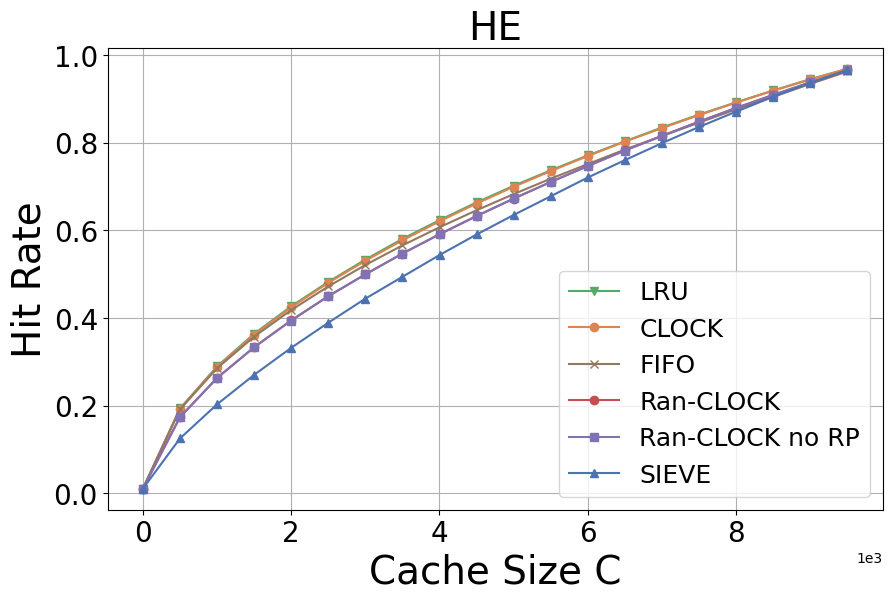

HE Average Hit Rates:
LRU: 0.6301152999999999
CLOCK: 0.628514
FIFO: 0.6173415499999999
Ran-CLOCK: 0.6080223499999999
Ran-CLOCK no RP: 0.6079535500000001
SIEVE: 0.5753432999999999


In [ ]:
c2, hr_ran_clock2 = sim_ran_clock_rp(trace2)
cn2, hr_ran_clock_no_rp2 = sim_ran_clock_no_rp(trace2)
cc2, hr_clock2 = sim_clock(trace2)
cs2, hr_sieve2 = sim_sieve(trace2)
cl2, hr_lru2 = sim_lru(trace2)
cf2, hr_fifo2 = sim_fifo(trace2)

plt.figure(figsize=(10,6))
ax = plt.gca()
ax.tick_params(axis='both', labelsize=20)
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.xaxis.get_major_formatter().set_scientific(True)
ax.xaxis.get_major_formatter().set_powerlimits((-1, 1))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.get_major_formatter().set_scientific(True)
ax.yaxis.get_major_formatter().set_powerlimits((-1, 1))
plt.plot(cl2, hr_lru2, color=palette[2], marker='v', label='LRU')
plt.plot(cc2, hr_clock2, color=palette[1], marker='o', label='CLOCK')
plt.plot(cf2, hr_fifo2, color=palette[5], marker='x', label='FIFO')
plt.plot(c2, hr_ran_clock2, color=palette[3], marker='o', label='Ran-CLOCK')
plt.plot(cn2, hr_ran_clock_no_rp2, color=palette[4], marker='s', label='Ran-CLOCK no RP')
plt.plot(cs2, hr_sieve2, color=palette[0], marker='^', label='SIEVE')

plt.xlabel('Cache Size C', fontsize=28)
plt.ylabel('Hit Rate', fontsize=28)
plt.legend(fontsize=18)
plt.title('HE', fontsize=28)
plt.grid(True)
plt.show()

avgs2 = [('SIEVE', np.mean(np.array(hr_sieve2))),
         ('CLOCK', np.mean(np.array(hr_clock2))),
         ('LRU', np.mean(np.array(hr_lru2))),
         ('Ran-CLOCK', np.mean(np.array(hr_ran_clock2))),
         ('Ran-CLOCK no RP', np.mean(np.array(hr_ran_clock_no_rp2))),
         ('FIFO', np.mean(np.array(hr_fifo2)))]
avgs2.sort(key=lambda x: x[1], reverse=True)
print("HE Average Hit Rates:")
for name, avg in avgs2:
    print(f"{name}: {avg}")

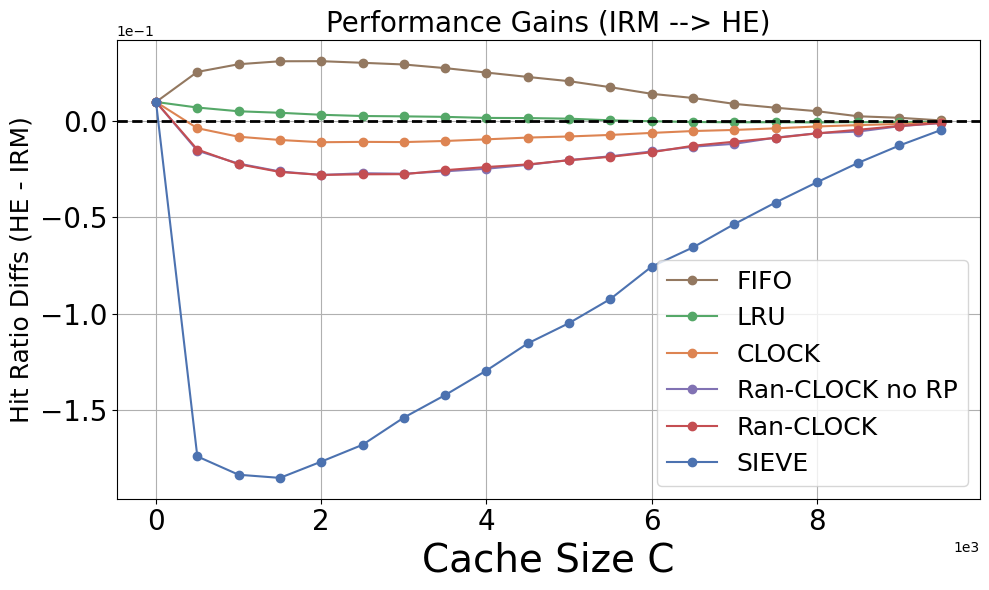

In [ ]:
policies = ["FIFO", "LRU", "CLOCK", "Ran-CLOCK no RP", "Ran-CLOCK", "SIEVE"]
irm_hr = [hr_fifo, hr_lru, hr_clock, hr_ran_clock_no_rp, hr_ran_clock, hr_sieve]
he_hr  = [hr_fifo2, hr_lru2, hr_clock2, hr_ran_clock_no_rp2, hr_ran_clock2, hr_sieve2]
colors = [palette[5], palette[2], palette[1], palette[4], palette[3], palette[0]]

rows = []
for name, irm, he in zip(policies, irm_hr, he_hr):
    irm = np.array(irm)
    he  = np.array(he)
    delta = he - irm
    for C, d in zip(c, delta):
        rows.append({"C": C, "policy": name, "delta_hr": d})

df_delta = pd.DataFrame(rows)
plt.figure(figsize=(10,6))
ax = plt.gca()
ax.tick_params(axis='both', labelsize=20)
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.xaxis.get_major_formatter().set_scientific(True)
ax.xaxis.get_major_formatter().set_powerlimits((-1, 1))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.get_major_formatter().set_scientific(True)
ax.yaxis.get_major_formatter().set_powerlimits((-1, 1))
for name, color in zip(policies, colors):
    sub = df_delta[df_delta["policy"] == name]
    plt.plot(sub["C"], sub["delta_hr"], marker='o', label=name, color=color)
plt.axhline(0, color='black', linewidth=2, linestyle='--')
plt.xlabel("Cache Size C", fontsize=28)
plt.ylabel("Hit Ratio Diffs (HE - IRM)", fontsize=18)
plt.title("Performance Gains (IRM --> HE)", fontsize=20)
plt.legend(fontsize=18)
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
# Data: 
# n_access; n_miss, n_cachefill, n_recycle, n_examined, sum_abit.
sieve = tg.sieve(4000)
sieve.run(trace1)
rclock = tg.ran_clock(4000)
rclock.run(trace1, rp=True)
rclock2 = tg.ran_clock(4000)
rclock2.run(trace1, rp=False)
clock = tg.clock(4000)
clock.run(trace1)
from trace_gen.lru_wrapper import lru as LRU 
lru = LRU(4000)
lru.run(trace1)
fifo = tg.fifo(4000)
fifo.run(trace1)

print("IRM Data at C=4000")
print("n_access; n_miss, n_cachefill, n_recycle, n_examined, sum_abit")
print(f"sieve: {sieve.data()}")
print(f"ran-clock: {rclock.data()}")
print(f"ran-clock no rp: {rclock2.data()}")
print(f"clock: {clock.data()}")
print(f"lru: {lru.data()}")
print(f"fifo: {fifo.data()}")

IRM Data at C=4000
n_access; n_miss, n_cachefill, n_recycle, n_examined, sum_abit
sieve: (1000000, 360430, 6445, 67973, 424403, 632527)
ran-clock: (1000000, 418426, 6445, 245296, 659722, 577876)
ran-clock no rp: (1000000, 418710, 6445, 245333, 660043, 577784)
clock: (1000000, 404514, 6445, 309333, 709847, 593885)
lru: (1000000, 412751, 6445)
fifo: (1000000, 449362, 6445)


In [11]:
sieve = tg.sieve(4000)
sieve.run(trace2)
rclock = tg.ran_clock(4000)
rclock.run(trace2, rp=True)
rclock2 = tg.ran_clock(4000)
rclock2.run(trace2, rp=False)
clock = tg.clock(4000)
clock.run(trace2)
from trace_gen.lru_wrapper import lru as LRU 
lru = LRU(4000)
lru.run(trace2)
fifo = tg.fifo(4000)
fifo.run(trace2)

print("HE Data at C=4000")
print("n_access; n_miss, n_cachefill, n_recycle, n_examined, sum_abit")
print(f"sieve: {sieve.data()}")
print(f"ran-clock: {rclock.data()}")
print(f"ran-clock no rp: {rclock2.data()}")
print(f"clock: {clock.data()}")
print(f"lru: {lru.data()}")
print(f"fifo: {fifo.data()}")

HE Data at C=4000
n_access; n_miss, n_cachefill, n_recycle, n_examined, sum_abit
sieve: (1000000, 529845, 5544, 207946, 733791, 463507)
ran-clock: (1000000, 445141, 5544, 304457, 745598, 551842)
ran-clock no rp: (1000000, 445879, 5544, 304157, 746036, 550982)
clock: (1000000, 417155, 5544, 367255, 780410, 581247)
lru: (1000000, 414324, 5544)
fifo: (1000000, 429542, 5544)


# Summary
- Under IRM workloads, SIEVE outperforms all other caches; but under HE workloads with the same IAD distribution its performance degrades significantly;
- n_cachefill is the positions in the trace where the 4000th unique block shows up. All caches require 6445 (5544) accesses to fill a capacity-4000 cache under IRM (HE).
- sum_abit counts the accumulated abit counter upon eviction. All clock-based caches have lower sum_abit under HE---sieve decays the most (632572 --> 463507; 26.73%).


# Modeling IRM


In [ ]:

# Mean-field solver and closed-form occ distribution for Ran-CLOCK(K)

def _normalize(p):
    p = np.asarray(p, dtype=np.float64)
    total = p.sum()
    if total <= 0:
        raise ValueError
    return p / total


def _x_minus_one(p, z, K):
    """Compute x_{k,-1} for a fixed z = m/x0.
    Returns array shape (n_objects,).
    """
    r = p / max(z, 1e-18)
    denom = np.ones_like(r)
    term = np.ones_like(r)
    for _ in range(K + 1):
        term *= r
        denom += term
    return 1.0 / denom


def ran_clock_fixed_point(p, cache_size, K=1, z_lower=1e-12, z_upper=1 - 1e-12, tol=1e-12, max_iter=80):
    """Find fixed point z = m/x0 for given cache_size C = n - sum x_{k,-1}.
    Returns (z, x_{k,-1} array).
    """
    p = _normalize(p)
    n = p.size
    target = n - int(cache_size)
    if target <= 0:
        return z_lower, np.zeros_like(p)
    low = max(z_lower, 1e-12)
    high = min(z_upper, 1 - 1e-12)
    last_x = None
    for _ in range(max_iter):
        mid = 0.5 * (low + high)
        x_minus1 = _x_minus_one(p, mid, K)
        diff = x_minus1.sum() - target
        last_x = x_minus1
        if abs(diff) <= tol:
            return mid, x_minus1
        if diff > 0:
            high = mid
        else:
            low = mid
    return 0.5 * (low + high), last_x if last_x is not None else _x_minus_one(p, 0.5 * (low + high), K)


def ran_clock_occ(p, z, K=1):
    """Closed-form occ distribution (x_{k,j}) for a fixed z = m/x0.
    Returns array shape (n_objects, K+2) with columns for j = -1,0,...,K.
    """
    p = _normalize(p)
    if z <= 0:
        raise ValueError("z must be positive (z = m/x0 in the paper)")
    r = p / z
    denom = np.ones_like(r)
    term = np.ones_like(r)
    for _ in range(K + 1):
        term *= r
        denom += term
    x_minus1 = 1.0 / denom
    states = [x_minus1]
    for j in range(K + 1):
        states.append((r ** (j + 1)) / denom)
    return np.stack(states, axis=1)


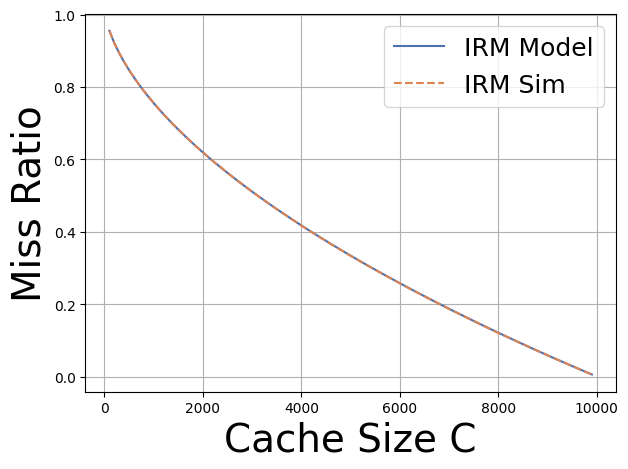

In [ ]:
C = np.arange(100, 10000, 100)
mr_irm_model = []
for c in C:
    z, xm1 = ran_clock_fixed_point(lmb, c, K=1)
    occ = ran_clock_occ(lmb, z, K=1)
    mr_irm_model.append(float(np.dot(lmb, occ[:, 0])))

mr_irm_sim = []
for c in C:
    rclock = tg.ran_clock(c)
    rclock.run(trace1, rp=True)
    mr_irm_sim.append(1-rclock.hitrate())

plt.plot(C, mr_irm_model, label='IRM Model', color=palette[0])
plt.plot(C, mr_irm_sim, label='IRM Sim', color=palette[1], linestyle='--')
plt.xlabel('Cache Size C', fontsize=28)
plt.ylabel('Miss Ratio', fontsize=28)
plt.legend(fontsize=18)
plt.grid(True)
plt.tight_layout()
plt.show()

# Modeling Phase-Type

(extremely slow...)

In [ ]:
from scipy.optimize import brentq

def ranclock_ph_fixed_point(alpha, rates, K, C):
    d = len(rates)
    T = np.diag(-rates) 
    mu = rates.reshape((d, 1)) 
    n = len(rates)
    if not np.isclose(np.sum(alpha), 1.0):
        raise ValueError
    if C <= 0 or C >= n:
        raise ValueError

    def solve_recurrence_for_fixed_z(z):
        R_diag = 1.0 / (rates + z)
        R = np.diag(R_diag)
        Y = [np.zeros((1, d))] * (K + 2)
        S_K = alpha @ R @ mu
        if np.isclose(1.0, S_K):
             return np.full((1, d), 1e10)
        A_K = S_K / (1.0 - S_K)
        H = [0.0] * (K + 1)
        H[K-1] = 1.0
        H[K] = A_K
        Y[K + 1] = (H[K-1] + H[K]) * alpha @ R

        for j in range(K - 1, 0, -1):
            Y[j + 1] = (H[j-1] * alpha + z * Y[j + 2]) @ R
            H[j] = Y[j + 1] @ mu

        Y[1] = (alpha + z * Y[2]) @ R
        H[0] = Y[1] @ mu
        T_inv = np.diag(-1.0 / rates)
        Y[0] = -z * Y[1] @ T_inv
        return Y

    def target_function(z):
        if z <= 0:
            return 1e10  

        Y = solve_recurrence_for_fixed_z(z)
        P_minus_1 = Y[0] @ np.ones((d, 1))
        P_total = sum(Y[j] @ np.ones((d, 1)) for j in range(K + 2))
        target_P_minus_1 = (n - C) / n
        return (P_minus_1 / P_total) - target_P_minus_1

    z_max = np.max(rates) * 10   
    try:
        z_star = brentq(target_function, a=1e-6, b=z_max)
    except ValueError as e:
        print(f"Error finding root z. Check the bounds (1e-6, {z_max}).")
        raise e
    
    Y_star = solve_recurrence_for_fixed_z(z_star)
    Y_0 = Y_star[1]
    Y_minus_1 = Y_star[0]
    P_total_star = sum(Y_star[j] @ np.ones((d, 1)) for j in range(K + 2))
    c = 1.0 / P_total_star
    h_minus_1_star = c * (Y_minus_1 @ mu).item()
    m_star = n * h_minus_1_star
    return m_star

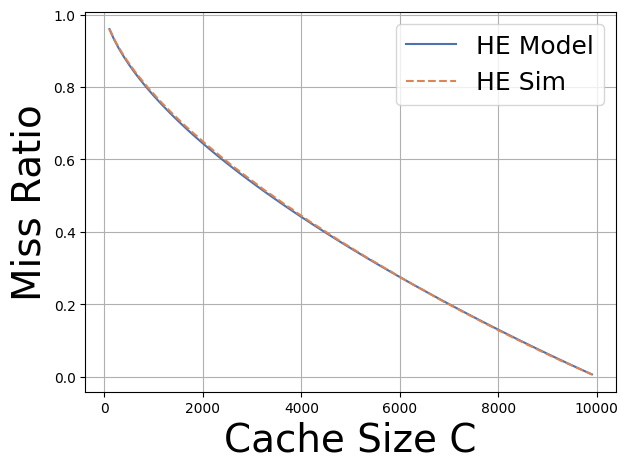

In [ ]:
mr_he_model = []
for c in C:
    mr = ranclock_ph_fixed_point(lmb, lmb, K=1, C=c)
    mr_he_model.append(mr.item())
    
mr_he_sim = []
for c in C:
    rclock = tg.ran_clock(c)
    rclock.run(trace2, rp=True)
    mr_he_sim.append(1-rclock.hitrate())

plt.plot(C, mr_he_model, label='HE Model', color=palette[0])
plt.plot(C, mr_he_sim, label='HE Sim', color=palette[1], linestyle='--')
plt.xlabel('Cache Size C', fontsize=28)
plt.ylabel('Miss Ratio', fontsize=28)
plt.legend(fontsize=18)
plt.grid(True)
plt.tight_layout()
plt.show()